<a href="https://colab.research.google.com/github/skdmlnatas/business-data/blob/main/Assignment3/Uihwan/reass3.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

## 1. Revisiting MLP of Assignment1

In [ ]:
import numpy as np
import matplotlib.cm as cm
import matplotlib.pyplot as plt


import torch
import torch.nn as nn
import torch.nn.functional as F
from torchvision import transforms, datasets

In [ ]:
from tensorflow.python.client import device_lib
device_lib.list_local_devices()

[name: "/device:CPU:0"
 device_type: "CPU"
 memory_limit: 268435456
 locality {
 }
 incarnation: 6192848389235220647
 xla_global_id: -1]

In [ ]:
print(torch.cuda.is_available())

False


In [ ]:
if torch.cuda.is_available():
    DEVICE = torch.device('cuda')
else:
    DEVICE = torch.device('cpu')

print('Using PyTorch version:', torch.__version__, ' Device:', DEVICE)

Using PyTorch version: 2.3.1+cu121  Device: cuda


In [ ]:
BATCH_SIZE = 32
EPOCHS = 10

In [ ]:
train_dataset = datasets.MNIST(root = "../data/MNIST",   # 데이터를 저장할 위치
                               train = True,     #데이터를 학습용으로 사용할 것인가요?
                               download = True,   # (root 위치에) 데이터를 저장할 것인가요?
                               transform = transforms.ToTensor())   # mnist를 저장하자마자 텐서로 전처리

test_dataset = datasets.MNIST(root = "../data/MNIST",
                              train = False,        # download는 이미 저장한 데이터가 있기 때문에 true로 하지 않음. 디폴트가 false인가봄.
                              transform = transforms.ToTensor())

train_loader = torch.utils.data.DataLoader(dataset = train_dataset,   # train_data를 배치 단위로 제공하시 위해서 사용.
                                           batch_size = BATCH_SIZE,
                                           shuffle = True)

test_loader = torch.utils.data.DataLoader(dataset = test_dataset,
                                          batch_size = BATCH_SIZE,
                                          shuffle = False)

Failed to download (trying next):
HTTP Error 403: Forbidden



100%|██████████| 9912422/9912422 [00:00<00:00, 16257500.02it/s]


Extracting ../data/MNIST/MNIST/raw/train-images-idx3-ubyte.gz to ../data/MNIST/MNIST/raw

Failed to download (trying next):
HTTP Error 403: Forbidden



100%|██████████| 28881/28881 [00:00<00:00, 497360.76it/s]


Extracting ../data/MNIST/MNIST/raw/train-labels-idx1-ubyte.gz to ../data/MNIST/MNIST/raw

Failed to download (trying next):
HTTP Error 403: Forbidden



100%|██████████| 1648877/1648877 [00:00<00:00, 4507495.82it/s]


Extracting ../data/MNIST/MNIST/raw/t10k-images-idx3-ubyte.gz to ../data/MNIST/MNIST/raw

Failed to download (trying next):
HTTP Error 403: Forbidden



100%|██████████| 4542/4542 [00:00<00:00, 2937176.81it/s]

Extracting ../data/MNIST/MNIST/raw/t10k-labels-idx1-ubyte.gz to ../data/MNIST/MNIST/raw







*   The code above loads the data with PyTorch function 'datasets' and 'DataLoader', and works only for MNIST.
*   Can we make our custom datasets and dataloader?
*   Please download a zip file from https://www.kaggle.com/datasets/andrewmvd/animal-faces, and upload the file to your Colab (Google Drive).

In [ ]:
from google.colab import drive
drive.mount('/content/drive')

Mounted at /content/drive


### (1) Using torchvision.transforms

In [ ]:
transform_train = transforms.Compose([ ## Data transformation only for train data. 데이터 전처리 과정을 순차적으로 연결.
    transforms.Resize(size=(256, 256)), ## Resizing the data into (256, 256)
    transforms.RandomRotation(30), ## 30 degree rotation (data augmentation). 최대 30도까지 무작위 회전

    transforms.ToTensor(), ## To 'Pytorch Tensor' -> Pytorch Deep Learning Models like CNN (we'll deal with it later on) get only tensor as an input
])
transform_val = transforms.Compose([ ## Data transformation only for validation (here, it works like the 'test' data...) data
    transforms.Resize(size=(256, 256)), ## Resizing the data into (256, 256). 아마 bilinear interpolation 사용.
    transforms.ToTensor() ## To 'Pytorch Tensor'
])

## Please note that the data augmentation technique is not usually implemented to validation/test dataset
## This is why we split transform_train and transform_val -- transform_val does not need
## transforms.RandomRotation(30), ## 30 degree rotation (data augmentation)

train_data = datasets.ImageFolder(root='/content/drive/MyDrive/intro-dl/afhq/train', transform=transform_train)
## Pytorch function datasets.ImageFolder organizes the data in root directory (here, '/content/drive/MyDrive/intro-dl/afhq/train')
## and applies transform_train as defined above.
val_data = datasets.ImageFolder(root='/content/drive/MyDrive/intro-dl/afhq/val', transform=transform_val)
## Pytorch function datasets.ImageFolder organizes the data in root directory (here, '/content/drive/MyDrive/intro-dl/afhq/val')
## and applies transform_val as defined above.

train_loader = torch.utils.data.DataLoader(train_data, batch_size=16, shuffle = True)
## Pytorch function DataLoader organizes the 'shuffled' (shuffle = True) data in train_data as defined above with the batch size of 16.
val_loader = torch.utils.data.DataLoader(val_data, batch_size=16, shuffle = True)
## Pytorch function DataLoader organizes the 'shuffled' (shuffle = True) data in val_data as defined above with the batch size of 16.


In [ ]:
train_data.class_to_idx ## It automatically catches the classes in train_data -> check it by yourself!
## (see /content/drive/MyDrive/intro-dl/afhq/val directory in your Google Drive)

{'cat': 0, 'dog': 1, 'wild': 2}

In [ ]:
dataiter = iter(train_loader)   # iter, next 배웠잖아. "이터레이터"
images, labels = next(dataiter)
## brings the next images and labels

In [ ]:
# transepose 공부

a = np.array([[[1, 2, 3],
               [4, 5, 6]],
              [[7, 8, 9],
               [10, 11, 12]]])

print(a, a.shape, np.transpose(a, (1, 0, 2)), np.transpose(a, (1, 2, 0)), a, sep = f'\n{10*"-"}\n', end = '\n\n')
print(a.transpose(1, 2, 0)[0, 1, 0])

# 바깥부터 안으로 들어가면서 0, 1, 2축
# 0->2, 1->0, 2->1    => 원래 1축이었던게 0축으로, 원래 2축이었던게 1축으로, 원래 0축이었던게 2축으로

[[[ 1  2  3]
  [ 4  5  6]]

 [[ 7  8  9]
  [10 11 12]]]
----------
(2, 2, 3)
----------
[[[ 1  2  3]
  [ 7  8  9]]

 [[ 4  5  6]
  [10 11 12]]]
----------
[[[ 1  7]
  [ 2  8]
  [ 3  9]]

 [[ 4 10]
  [ 5 11]
  [ 6 12]]]
----------
[[[ 1  2  3]
  [ 4  5  6]]

 [[ 7  8  9]
  [10 11 12]]]

2


In [ ]:
b = np.random.rand(1, 2, 3)
b

array([[[0.67998605, 0.31234678, 0.93152574],
        [0.06258189, 0.89358624, 0.59350829]]])

In [ ]:
print(b.transpose(1,2,0).shape)

(2, 3, 1)


f: Figure(3000x500), (), <class 'matplotlib.figure.Figure'>
axes: [<Axes: > <Axes: > <Axes: > <Axes: > <Axes: > <Axes: > <Axes: > <Axes: >], (8,), <class 'numpy.ndarray'>
<class 'matplotlib.axes._axes.Axes'>
torch.Size([16, 3, 256, 256])
tensor([[[0.7843, 0.9922, 1.0000, 0.9961, 0.9647],
         [0.7451, 0.9373, 0.9765, 0.9922, 0.9843],
         [0.8824, 0.7843, 0.8706, 0.9922, 0.9804],
         [0.9490, 0.8314, 0.8314, 0.9412, 0.9569],
         [0.9490, 0.9333, 0.9529, 0.9294, 0.9765]],

        [[0.4980, 0.7490, 0.7686, 0.7765, 0.7255],
         [0.4392, 0.6863, 0.7412, 0.7765, 0.7765],
         [0.5490, 0.5020, 0.6118, 0.7765, 0.7843],
         [0.6353, 0.5569, 0.5569, 0.6980, 0.7412],
         [0.6353, 0.6588, 0.6980, 0.6980, 0.7529]],

        [[0.2510, 0.5216, 0.5412, 0.5529, 0.4784],
         [0.1804, 0.4510, 0.5176, 0.5608, 0.5569],
         [0.2824, 0.2510, 0.3686, 0.5608, 0.5608],
         [0.3725, 0.2980, 0.2980, 0.4667, 0.5137],
         [0.3725, 0.3882, 0.4353, 0.4627, 0.

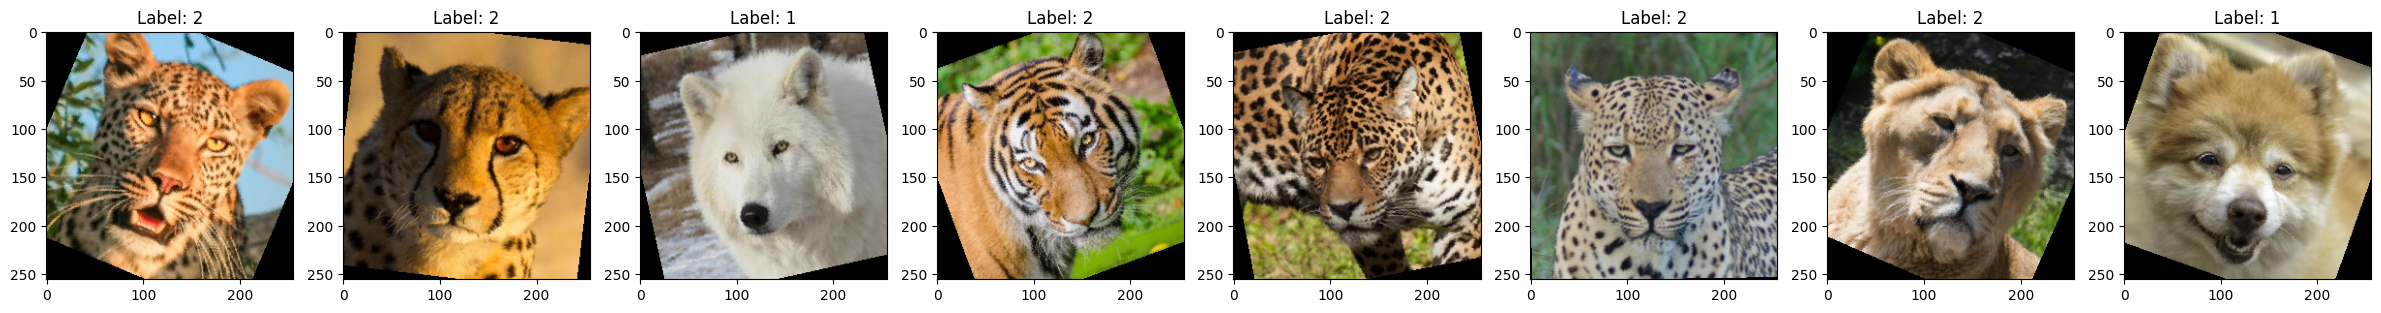

In [ ]:
def show_imgs(imgs, labels, preds=None):    # predictions
    f, axes= plt.subplots(1, 8, figsize=(30,5))   # plt 자체가 데이터를 시각화 하는 것에 관련된 작업을 하는 건데, 이 중에 시각화 된 그 부분을 '플롯'이라 함
    print(f'f: {f}, {np.shape(f)}, {type(f)}')  # numpy 배열이 아니라 shape은 ()이라고 나오는 거임.
    print(f'axes: {axes}, {np.shape(axes)}, {type(axes)}')   # numpy.ndarray: n-dimensional array. 원소는 그냥 같은 타입이기만 하면 됨.
    print(type(axes[1]))  # 그냥 하나의 그래프(?)를 담고있는 컨테이너임.
    for i, axis in enumerate(axes):
        if i == 0:
          # print(type(imgs[i]))
          print(imgs.shape)   # 이미지가 16개 밖에 없네?  -> 위에서 트레인로더의 배치 사이즈를 16으로 했으니까
          print(imgs[i,:,100:105,100:105])  # 이미 0~1 사이로 스케일링 돼있네..
          print(np.transpose(imgs[i].numpy(), (1, 2, 0)).shape)

        # axes[i].imshow(np.squeeze(np.transpose(imgs[i].numpy(), (1, 2, 0))))   # 얘도 에러 없음.
        axes[i].imshow(np.squeeze(np.transpose(imgs[i].numpy(), (1, 2, 0))), cmap=cm.gray)  # 이렇게 나와있는 코드가 있어서 써봤는데, 에러는 없지만 형식이 좀 이상하긴 함.
        # imshow: 이미지를 보여줄게
        # imgs[i].numpy(): 인수로 받아왔던 (텐서 형태의) 이미지 데이터를 NumPy 배열로 변환. 그래야 저렇게 transpose 할 수 있으니까(?)
        # (c, h, w) -> (h, w, c) 순서 변환. imshow가 원하거든
        # np.squeeze(np.transpose(imgs[i].numpy(), (1, 2, 0))) 이게 squeeze 묶음. 불필요한 차원을 제거. e.g.(1, h, w, c) -> (h, w, c)

        axes[i].set_title(f'Label: {labels[i].numpy()}')
        if preds != None:
            axes[i].set_xlabel(f'Pred: {np.argmax(preds[i].numpy())}')
            # np.argmax: 배열에서 가장 큰 값을 가지는 요소의 인덱스.
            # pred 값은 (0:0.8, 1:0.1, 2:0.1) 이런 식으로 되어있는 거야?
            # x축 레이블 위치에다가 넣어놨네? 자연스럽게 보이기만 하면 되는 거라서?
    plt.show()

show_imgs(images, labels)

## shows the sample train_data
## 30 degree rotation!

### (2) Making a customized datasets and dataloader

In [ ]:
import os  # os: Operating System: 운영 체제.
# 파이썬 프로그램에서 운영 체제와 관련된 다양한 기능을 사용할 수 있도록
# 파일 및 디렉토리 관리, 환경 변수, 프로세스 관리, 셸 명령 실행

In [ ]:
train_cat = os.listdir('/content/drive/MyDrive/intro-dl/afhq/train/cat')  # listdir: 디렉토리 내에 존재하는 파일과 디렉토리 목록을 리스트 형태로 반환
train_dog = os.listdir('/content/drive/MyDrive/intro-dl/afhq/train/dog')
train_wild = os.listdir('/content/drive/MyDrive/intro-dl/afhq/train/wild')

In [ ]:
# WARNING: DO NOT RUN THIS CODE. IT TAKES TOO LONG TIME TO GET THE RESULT.

train_cat_image = []
train_dog_image = []
train_wild_image = []

train_cat_target = []
train_dog_target = []
train_wild_target = []

for i in range(len(train_cat)):
  image = plt.imread(os.path.join('/content/drive/MyDrive/intro-dl/afhq/train/cat', train_cat[i]))
  train_cat_image.append(image)
  train_cat_target.append(0)

for i in range(len(train_dog)):
  image = plt.imread(os.path.join('/content/drive/MyDrive/intro-dl/afhq/train/dog', train_dog[i]))
  train_dog_image.append(image)
  train_dog_target.append(1)

for i in range(len(train_wild)):
  image = plt.imread(os.path.join('/content/drive/MyDrive/intro-dl/afhq/train/wild', train_wild[i]))
  train_wild_image.append(image)
  train_wild_target.append(2)

Question 1."결합할" 경로를 설정함.

## 2. Backpropagation and PyTorch Autograd

In [ ]:
import torch  # pytorch 라이브러리. 딥러닝 모델링 관련 소스들.

In [ ]:
w = torch.tensor(3.0, requires_grad = True) ## requires_grad = True: it saves the gradient
# torch.tensor: 텐서로 만들기. 그니까 그냥 3.0 스칼라 텐서를 만드는 거임.

In [ ]:
y = w**3 + 10

In [ ]:
y.backward() ## backward() calculates the derivative 해서 w.grad에 저장도 해줌. y를 계산하는데 연관된 모든 x들에 대해 dy/dx가 계산.

In [ ]:
print(f'Differentiating y by w: {w.grad}') ## check it by yourself!! dy/dw = 3*w^2 ..., so

Differentiating y by w: 27.0


In [ ]:
## Another example with the loss fuction
import torch
import torch.nn as nn   # Neural Networks

In [ ]:
x = torch.ones(5)  # input
y = torch.zeros(3)  # output
print(x,y, sep='\n')

w = torch.randn(5, 3, requires_grad=True) # weight
# gradient 나중에 쓰려고 해당 텐서에 대한 연산 과정을 기록
b = torch.randn(3, requires_grad=True) # bias
print(w,b, sep='\n')

tensor([1., 1., 1., 1., 1.])
tensor([0., 0., 0.])
tensor([[ 0.7578,  0.7852,  0.3454],
        [ 0.2001, -1.3869,  0.5648],
        [-0.6559, -0.9822, -2.0279],
        [-0.7860,  0.3705,  1.8888],
        [-0.5125,  1.4305,  1.1729]], requires_grad=True)
tensor([ 1.9796, -1.0874, -0.3332], requires_grad=True)


In [ ]:
z = torch.matmul(x, w) + b # z = wx + b. 아 *는 그냥 같은 위치끼리 곱하는거래.
loss_fn = nn.MSELoss() # loss function

In [ ]:
print(z)

tensor([-3.5881, -0.9544, -0.0560], grad_fn=<AddBackward0>)


In [ ]:
loss = loss_fn(z, y)

loss.backward() # 여기서 w.grad, b.grad가 생기는 거지. 업데이트는 안함.

In [ ]:
print(loss)

tensor(4.5962, grad_fn=<MseLossBackward0>)


In [ ]:
print(f'Differentiating loss by w :\n {w.grad}')
print(f'Differentiating loss by b : {b.grad}')

Differentiating loss by w :
 None
Differentiating loss by b : None


<ipython-input-84-8349bc3d0488>:1: UserWarning: The .grad attribute of a Tensor that is not a leaf Tensor is being accessed. Its .grad attribute won't be populated during autograd.backward(). If you indeed want the .grad field to be populated for a non-leaf Tensor, use .retain_grad() on the non-leaf Tensor. If you access the non-leaf Tensor by mistake, make sure you access the leaf Tensor instead. See github.com/pytorch/pytorch/pull/30531 for more informations. (Triggered internally at aten/src/ATen/core/TensorBody.h:489.)
  print(f'Differentiating loss by w :\n {w.grad}')
<ipython-input-84-8349bc3d0488>:2: UserWarning: The .grad attribute of a Tensor that is not a leaf Tensor is being accessed. Its .grad attribute won't be populated during autograd.backward(). If you indeed want the .grad field to be populated for a non-leaf Tensor, use .retain_grad() on the non-leaf Tensor. If you access the non-leaf Tensor by mistake, make sure you access the leaf Tensor instead. See github.com/pyto

In [ ]:
x = torch.ones(5)  # input
y = torch.zeros(3)  # output

w = torch.randn(5, 3, requires_grad=True) # weight
# gradient 나중에 쓰려고 해당 텐서에 대한 연산 과정을 기록
b = torch.randn(3, requires_grad=True) # bias

for i in range(100):
    z = torch.matmul(x, w) + b # z = wx + b. 아 *는 그냥 같은 위치끼리 곱하는거래.
    loss_fn = nn.MSELoss()

    loss = loss_fn(z, y)
    loss.backward()

    if w.grad is None or b.grad is None:
        raise ValueError("Gradient is None. Check the computation graph.")

    with torch.no_grad():
        w -= 0.01 * w.grad
        b -= 0.01 * b.grad

        w.grad.zero_()
        b.grad.zero_()

    if i % 10 == 0:
        print(f'Epoch {i}, Loss: {loss.item()}')
print(f'Differentiating loss by w :\n {w.grad}')
print(f'Differentiating loss by b : {b.grad}')
print(loss)

Epoch 0, Loss: 3.2556540966033936
Epoch 10, Loss: 1.4390071630477905
Epoch 20, Loss: 0.6360445618629456
Epoch 30, Loss: 0.2811332941055298
Epoch 40, Loss: 0.12426168471574783
Epoch 50, Loss: 0.05492396652698517
Epoch 60, Loss: 0.024276554584503174
Epoch 70, Loss: 0.010730321519076824
Epoch 80, Loss: 0.004742819350212812
Epoch 90, Loss: 0.0020963356364518404
Differentiating loss by w :
 tensor([[0., 0., 0.],
        [0., 0., 0.],
        [0., 0., 0.],
        [0., 0., 0.],
        [0., 0., 0.]])
Differentiating loss by b : tensor([0., 0., 0.])
tensor(0.0010, grad_fn=<MseLossBackward0>)


순전파: 입력값 들어오면 계산 후 결과값 도출
역전파: 순전파에서 더 나은 결과를 낼 수 있는 방향으로 파라미터 업그레이드.
pytorch에서는 Autograd를 사용

## 3. Vanishing Gradient Problem

In [ ]:
import matplotlib.pyplot as plt
import numpy as np
import pandas as pd
import tensorflow as tf
import warnings
from matplotlib.colors import ListedColormap
from mlxtend.plotting import plot_decision_regions
from pylab import rcParams
# pylab: Matplotlib 라이브러리의 일부인 Python의 모듈. 플롯 생성, 조작 관련.
# rcParams: 플롯의 기본 모양을 전체적으로 맞춤 설정
from sklearn.datasets import make_circles, make_moons
# sklearn: Scikit-learn. 기계 학습 알고리즘, 전처리 기술, 모델 평가 및 검증 도구를 지원.
from sklearn.model_selection import train_test_split
from tensorflow.keras.layers import Dense
from tensorflow.keras.models import Sequential

In [ ]:
!pip install --upgrade tensorflow

In [ ]:
np.set_printoptions(suppress=True)   # 과학 표기법 사용 안함. 읽기 편하게 하려고 한 듯.
zero_one_colormap = ListedColormap(('white', 'red'))  # 이진 컬러맵. 0=흰, 1=빨
rcParams['figure.figsize'] = 14, 7
rcParams['axes.facecolor'] = '#383838'

In [ ]:
X, y = make_circles(n_samples = 1000,      # X: 좌표, y: 점의 클래스.(0 또는 1)
# circles는 2개의 클래스만 만듦
                    factor=0.85,    # 클래스 간 거리. 내부 원과 외부 원 사이의 거리
                    random_state=2021,  # 랜덤 시드
                    noise=0.05)

In [ ]:
print(np.shape(X[:,0]))

(1000,)


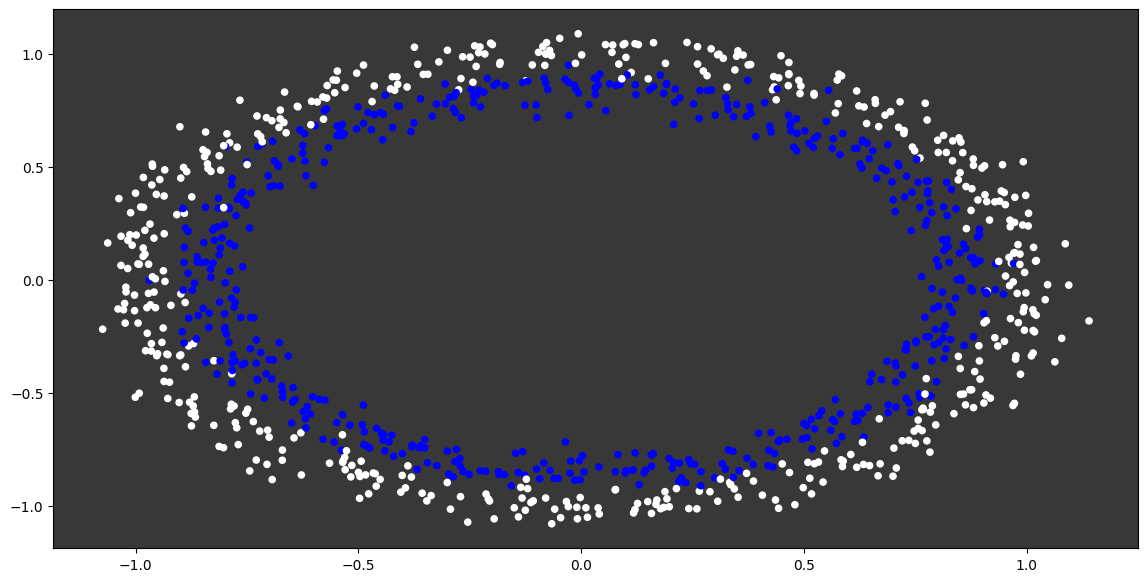

In [ ]:
plt.scatter(X[:,0],X[:,1],    # 그림 그림
            c=y, s=20,
            cmap = zero_one_colormap)
plt.show()

In [ ]:
X_train, X_test, y_train, y_test = train_test_split(X, y,               # train/test 데이터 분리
                                                    test_size=0.33,     # 데이터셋에서 33%만 테스트 용으로 분리. 원래 X는 나눠져 있는게 아니네.
                                                    random_state=42)    # 무작위로 섞는 방식을 고정. np.random.seed()랑 비슷.

In [ ]:
def get_model(inp_activation):     # 모델 만들기
  model = Sequential()  # 쌓아나가려고.
  model.add(Dense(10,input_dim=2, activation=inp_activation))
  model.add(Dense(10, activation = inp_activation))
  model.add(Dense(10, activation = inp_activation))
  model.add(Dense(10, activation = inp_activation))
  model.add(Dense(10, activation = inp_activation))
  model.add(Dense(10, activation = inp_activation))
  model.add(Dense(10, activation = inp_activation))
  model.add(Dense(10, activation = inp_activation))
  model.add(Dense(10, activation = inp_activation))
  model.add(Dense(10, activation = inp_activation))
  model.add(Dense(10, activation = inp_activation))
  model.add(Dense(1, activation="sigmoid"))
  model.compile(loss='binary_crossentropy',    # loss(손실함수): 모델이 예측한 값과 실제 값의 차이
                optimizer='adam',              # optimizer: 웨이트 업데이트. gd처럼.
                metrics=['accuracy'])          # metrics: 모델의 성능을 평가하는 기준.
  return model

In [ ]:
def change_in_weight_gradient(old_weight, new_weight, learning_rate):     # weight 변화를 계산하는 함수 만들기
  gradient = (old_weight - new_weight)/ learning_rate                     # 식이 이해가 잘 안되는데... 나중에 어떻게 쓰는지 보고 이해해보자
  # 아... 업데이트가 다 끝난 후에 gradient를 역으로 계산하네.. old-grad*lr=new니까
  pct_change_weight = abs(100*(old_weight - new_weight)/ old_weight)
  return gradient, pct_change_weight

In [ ]:
sigmoid_model = get_model("sigmoid")  # activation을 sigmoid로. 0에서 1사이로 부드럽게 생긴 거.

/usr/local/lib/python3.10/dist-packages/keras/src/layers/core/dense.py:87: UserWarning: Do not pass an `input_shape`/`input_dim` argument to a layer. When using Sequential models, prefer using an `Input(shape)` object as the first layer in the model instead.
  super().__init__(activity_regularizer=activity_regularizer, **kwargs)


In [ ]:
sigmoid_model.summary()  # 모델의 구조를 대략 볼 수 있는 함수

Model: "sequential"

┏━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━┓
┃ Layer (type)                         ┃ Output Shape                ┃         Param # ┃
┡━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━┩
│ dense (Dense)                        │ (None, 10)                  │              30 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ dense_1 (Dense)                      │ (None, 10)                  │             110 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ dense_2 (Dense)                      │ (None, 10)                  │             110 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ dense_3 (Dense)                      │ (None, 10)                  │             110 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ dense_4 (Dense)                      │ (None, 10)                  │             110 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ dense_5 (Dense)                      │ (None, 10)                  │             110 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ dense_6 (Dense)                      │ (None, 10)                  │             110 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ dense_7 (Dense)                      │ (None, 10)                  │             110 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ dense_8 (Dense)                      │ (None, 10)                  │             110 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ dense_9 (Dense)                      │ (None, 10)                  │             110 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ dense_10 (Dense)                     │ (None, 10)                  │             110 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ dense_11 (Dense)                     │ (None, 1)                   │              11 │
└──────────────────────────────────────┴─────────────────────────────┴─────────────────┘

 Total params: 1,141 (4.46 KB)

 Trainable params: 1,141 (4.46 KB)

 Non-trainable params: 0 (0.00 B)

In [ ]:
sigmoid_model_first_layer_weights = sigmoid_model.get_weights()[0][0]  # 1층의 1번째 노드에서 나가는 weight(일걸?)

In [ ]:
sigmoid_model_first_layer_weights # [0][0] 가져와서 확인.

array([ 0.6427302 , -0.04767346,  0.3547998 , -0.33262494, -0.26090956,
        0.43531877,  0.15171415,  0.64796716, -0.70590556, -0.28839165],
      dtype=float32)

In [ ]:
sigmoid_history = sigmoid_model.fit(X_train, y_train, epochs = 1,   # fit: 학습 시키는 메서드.
                            validation_data = (X_test, y_test))     # test로 빼둔 데이터로 validation에 사용.

21/21 ━━━━━━━━━━━━━━━━━━━━ 5s 17ms/step - accuracy: 0.4873 - loss: 0.8666 - val_accuracy: 0.5242 - val_loss: 0.7896


In [ ]:
sigmoid_model_first_layer_weights_updated = sigmoid_model.get_weights()[0][0]

In [ ]:
sigmoid_model_first_layer_weights_updated   # 업데이트 된 파라미터 확인

array([ 0.64272875, -0.04767641,  0.35480258, -0.332628  , -0.2609125 ,
        0.43531853,  0.15171264,  0.64796555, -0.7059047 , -0.28839394],
      dtype=float32)

In [ ]:
s_gradient, s_weight_change = change_in_weight_gradient(sigmoid_model_first_layer_weights,   # change_in_weight_gradient: 주어진 기울기와, 해당 기울기 대한 가중치의 변화를 계산
                                                        sigmoid_model_first_layer_weights_updated,
                                                        sigmoid_model.optimizer.get_config()["learning_rate"])   # 그레디언트에 따른 파라미터 변화 확인
                                                        # get_config(): dict 형태로 변환.
                                                        # ["learning_rate"] 키 찾아서 요소 가져오기.


In [ ]:
s_gradient

array([ 0.00143051,  0.00294298, -0.00277162,  0.00306964,  0.00295043,
        0.00023842,  0.00150502,  0.00160933, -0.00083446,  0.00229478],
      dtype=float32)

In [ ]:
s_weight_change

array([0.00022257, 0.0061732 , 0.00078118, 0.00092285, 0.00113082,
       0.00005477, 0.00099201, 0.00024837, 0.00011821, 0.00079572],
      dtype=float32)

In [ ]:
activation_model = get_model("relu")   # 엑티베이션 func만 relu로 바꿔서 다시

In [ ]:
activation_model_old_first_layer_weight = activation_model.get_weights()[0][0]    #가져와서 확인
activation_model_old_first_layer_weight

array([ 0.33825487, -0.06644112, -0.21444637, -0.60034764,  0.52872795,
        0.306266  , -0.03046119,  0.12193996,  0.35443527, -0.6602022 ],
      dtype=float32)

In [ ]:
activation_history = activation_model.fit(X_train, y_train, epochs = 1,
                                          validation_data = (X_test, y_test))

21/21 ━━━━━━━━━━━━━━━━━━━━ 5s 16ms/step - accuracy: 0.5014 - loss: 0.6934 - val_accuracy: 0.4818 - val_loss: 0.6931


In [ ]:
activation_model_updated_first_layer_weight = activation_model.get_weights()[0][0]

In [ ]:
activation_model_updated_first_layer_weight   # 여기서 나왔어야 할 질문이지. 음수인 weight가 왜 0이 되지 않았냐고.

array([ 0.3299207 , -0.06598003, -0.21316664, -0.6012593 ,  0.53408235,
        0.29923922, -0.02527857,  0.11929507,  0.3444552 , -0.663644  ],
      dtype=float32)

In [ ]:
relu_gradient, relu_weight_change = change_in_weight_gradient(activation_model_old_first_layer_weight,
                                                              activation_model_updated_first_layer_weight,
                                                              activation_model.optimizer.get_config()["learning_rate"])

In [ ]:
relu_gradient

array([ 8.33416  , -0.4610866, -1.2797265,  0.911653 , -5.354404 ,
        7.026791 , -5.182618 ,  2.6448889,  9.980052 ,  3.4418104],
      dtype=float32)

In [ ]:
relu_weight_change   # 음.. 확실히 sigmoid보다 빠르네
# 음수인 weight가 왜 학습이 되는 거죠?? -> 여기서 할 질문이 아니라
# relu는 weight에다 씌우는게 아니라 A(X)에다 씌우는 거니까.

NameError: name 'relu_weight_change' is not defined

## Question 3.
Check out this YouTube and write a line-by-line explanation of the code above -- ChatGPT allowed.   
https://youtube.com/watch?v=wTyZqtJyp5g

## 4. Regression

In [ ]:
from sklearn.model_selection import train_test_split
import matplotlib.pyplot as plt
import numpy as np
from sklearn import datasets, linear_model, metrics

In [ ]:
data_url = "http://lib.stat.cmu.edu/datasets/boston" ## Loading Boston Housing Dataset -- a famous dataset for linear regression
raw_df = pd.read_csv(data_url, sep="\s+",
           skiprows=22, header=None)  # 맨 위에 22줄은 이상한 거 적혀있네..

In [ ]:
X = np.hstack([raw_df.values[::2, :],  # raw_df: Pandas DataFrame 객체.
        raw_df.values[1::2, :2]])   # 짝수 행은 다, 홀수 행은 두번째 열만. 이라는게 맨 마지막 MEDV만 빼고 다 가져온다는 뜻인 듯.
y = raw_df.values[1::2, 2]  # 그거를 얘가 가져왔네

In [ ]:
X


array([[  0.00632,  18.     ,   2.31   , ...,  15.3    , 396.9    ,
          4.98   ],
       [  0.02731,   0.     ,   7.07   , ...,  17.8    , 396.9    ,
          9.14   ],
       [  0.02729,   0.     ,   7.07   , ...,  17.8    , 392.83   ,
          4.03   ],
       ...,
       [  0.06076,   0.     ,  11.93   , ...,  21.     , 396.9    ,
          5.64   ],
       [  0.10959,   0.     ,  11.93   , ...,  21.     , 393.45   ,
          6.48   ],
       [  0.04741,   0.     ,  11.93   , ...,  21.     , 396.9    ,
          7.88   ]])

In [ ]:
y


array([24. , 21.6, 34.7, 33.4, 36.2, 28.7, 22.9, 27.1, 16.5, 18.9, 15. ,
       18.9, 21.7, 20.4, 18.2, 19.9, 23.1, 17.5, 20.2, 18.2, 13.6, 19.6,
       15.2, 14.5, 15.6, 13.9, 16.6, 14.8, 18.4, 21. , 12.7, 14.5, 13.2,
       13.1, 13.5, 18.9, 20. , 21. , 24.7, 30.8, 34.9, 26.6, 25.3, 24.7,
       21.2, 19.3, 20. , 16.6, 14.4, 19.4, 19.7, 20.5, 25. , 23.4, 18.9,
       35.4, 24.7, 31.6, 23.3, 19.6, 18.7, 16. , 22.2, 25. , 33. , 23.5,
       19.4, 22. , 17.4, 20.9, 24.2, 21.7, 22.8, 23.4, 24.1, 21.4, 20. ,
       20.8, 21.2, 20.3, 28. , 23.9, 24.8, 22.9, 23.9, 26.6, 22.5, 22.2,
       23.6, 28.7, 22.6, 22. , 22.9, 25. , 20.6, 28.4, 21.4, 38.7, 43.8,
       33.2, 27.5, 26.5, 18.6, 19.3, 20.1, 19.5, 19.5, 20.4, 19.8, 19.4,
       21.7, 22.8, 18.8, 18.7, 18.5, 18.3, 21.2, 19.2, 20.4, 19.3, 22. ,
       20.3, 20.5, 17.3, 18.8, 21.4, 15.7, 16.2, 18. , 14.3, 19.2, 19.6,
       23. , 18.4, 15.6, 18.1, 17.4, 17.1, 13.3, 17.8, 14. , 14.4, 13.4,
       15.6, 11.8, 13.8, 15.6, 14.6, 17.8, 15.4, 21

NumPy 라이브러리에서 배열을 결합하는 데 사용되는 함수들.
hastack: 수평으로 배열을 쌓음
vstack: 수직으로
concatenate: 지정된 축을 따라

In [ ]:
X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.4, random_state=1)

X와 y를 각각 트레인과 테스트로 나눔.

In [ ]:
reg = linear_model.LinearRegression() ## LR Model of Scikit-learn
reg.fit(X_train, y_train)     # fit: 모델을 학습시킴!!

LinearRegression()

In [ ]:
# regression coefficients
print('Coefficients: ', reg.coef_)   # 선형이니까. x 앞에 계수 딱 13개 나오나보네.. 맞네 한 줄에 14갠데 y 빼면 13개네

# variance score: 1 means perfect prediction
print('Variance score: {}'.format(reg.score(X_test, y_test)))   # 0~1

Coefficients:  [ -0.0895714    0.06731329   0.05046492   2.18579583 -17.20539752
   3.63606995   0.0020558   -1.36602886   0.28957672  -0.01227001
  -0.83488185   0.00940361  -0.50400832]
Variance score: 0.720905667266174


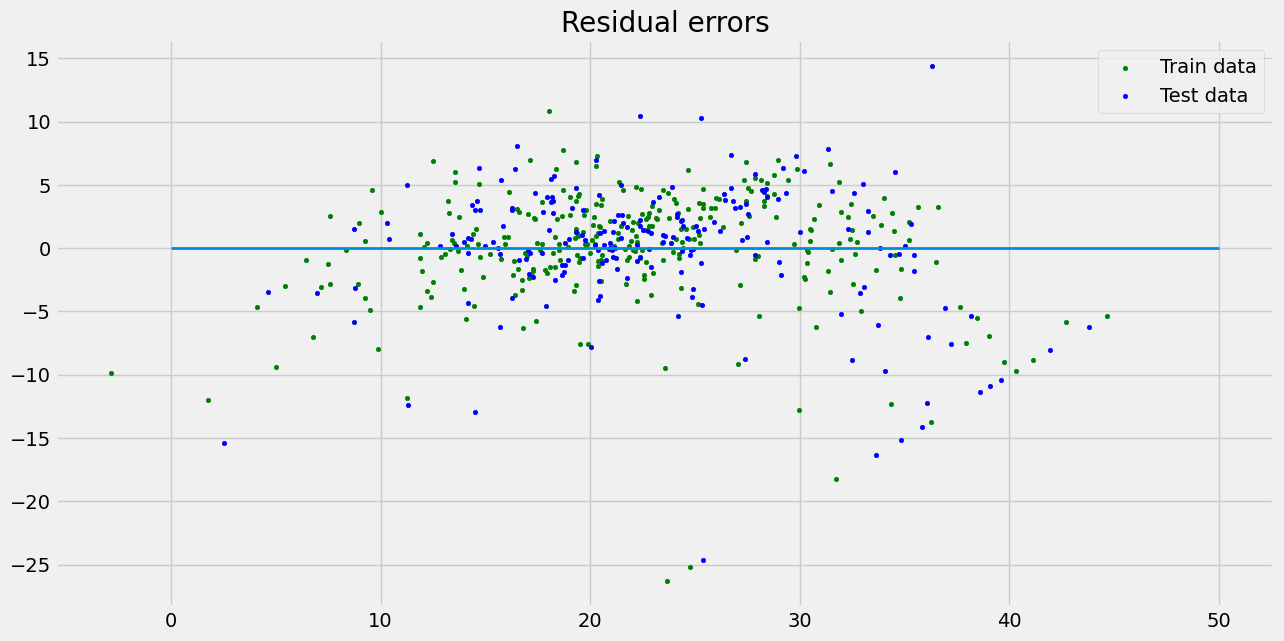

In [ ]:

# plot for residual error

# setting plot style
plt.style.use('fivethirtyeight')

# plotting residual errors in training data
plt.scatter(reg.predict(X_train),
            reg.predict(X_train) - y_train,
            color="green", s=10,
            label='Train data')

# plotting residual errors in test data
plt.scatter(reg.predict(X_test),
            reg.predict(X_test) - y_test,
            color="blue", s=10,
            label='Test data')

# plotting line for zero residual error
plt.hlines(y=0, xmin=0, xmax=50, linewidth=2)

# plotting legend
plt.legend(loc='upper right')

# plot title
plt.title("Residual errors")

# method call for showing the plot
plt.show()

In [ ]:
## 1. Sigmoid
import torch
import torch.nn as nn

class DenseBlock(nn.Module):
	def __init__(self, in_dim, out_dim):
		super(DenseBlock, self).__init__()
		self.dense = nn.Linear(in_dim, out_dim)
		self.act = nn.Sigmoid() # activation function

	def forward(self, x):
		out = self.act(self.dense(x))
		return out

In [ ]:
## 2. Tanh [Hyperbolic tangent]
import torch
import torch.nn as nn

class DenseBlock(nn.Module):
	def __init__(self, in_dim, out_dim):
		super(DenseBlock, self).__init__()
		self.dense = nn.Linear(in_dim, out_dim)
		self.act = nn.Tanh() # activation function

	def forward(self, x):
		out = self.act(self.dense(x))
		return out

In [ ]:
## 3. ReLU
import torch
import torch.nn as nn

class DenseBlock(nn.Module):
	def __init__(self, in_dim, out_dim):
		super(DenseBlock, self).__init__()
		self.dense = nn.Linear(in_dim, out_dim)
		self.act = nn.ReLU() # activation function

	def forward(self, x):
		out = self.act(self.dense(x))
		return out

In [ ]:
## 4. Leaky ReLU
import torch
import torch.nn as nn

class DenseBlock(nn.Module):
	def __init__(self, in_dim, out_dim):
		super(DenseBlock, self).__init__()
		self.dense = nn.Linear(in_dim, out_dim)
		self.act = nn.LeakyReLU() # activation function

	def forward(self, x):
		out = self.act(self.dense(x))
		return out

In [ ]:
import torch
import torch.nn as nn

class Maxout(nn.Module):
	def __init__(self, in_features, out_features, num_units=2):
		super(Maxout, self).__init__()
		self.num_units = num_units
		self.linear = nn.ModuleList([nn.Linear(in_features, out_features) for _ in range(num_units)])

	def forward(self, x):
		outputs = [layer(x) for layer in self.linear]
		maxout = torch.max(torch.stack(outputs), dim=0)[0]
		return maxout

class DenseBlockMaxout(nn.Module):
	def __init__(self, in_dim, out_dim, num_units=2):
		super(DenseBlockMaxout, self).__init__()
		self.dense = Maxout(in_dim, out_dim, num_units)

	def forward(self, x):
		out = self.dense(x)
		return out

In [ ]:
import torch
import torch.nn as nn

class DenseBlockELU(nn.Module):
	def __init__(self, in_dim, out_dim):
		super(DenseBlockELU, self).__init__()
		self.dense = nn.Linear(in_dim, out_dim)
		self.act = nn.ELU() # ELU activation function

	def forward(self, x):
		out = self.act(self.dense(x))
		return out

In [ ]:
import torch
import torch.nn as nn

class DenseBlockGELU(nn.Module):
	def __init__(self, in_dim, out_dim):
		super(DenseBlockGELU, self).__init__()
		self.dense = nn.Linear(in_dim, out_dim)
		self.act = nn.GELU() # GELU activation function

	def forward(self, x):
		out = self.act(self.dense(x))
    return out

가우스 누적 분포 함수를 입력에 적용하여 ReLU와 시그모이드 함수의 특성을 원활하게 혼합하는 활성화 함수